# Imports and meshcat

In [1]:
import numpy as np
import os

from pydrake.all import (
    AddDefaultVisualization,
    Simulator,
    StartMeshcat,
    DiscreteContactApproximation,
    RobotDiagramBuilder,
    VectorLogSink,
    MosekSolver,
)

from src.MyPlanner import OneStepPlanner
from src.MyTerrain import Terrain
from src.MyController import HybridController, DynamicTrajectorySource
from src.MyGCS import GCS
from utils.utils_urdf import load_urdf_file, add_boxes_urdf_from_terrain, ConfigureParser

enter path for mosek

In [2]:

os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/ikozaslan/Documents/github_workspace/drake_workspace/drake_venv/lib/python3.13/site-packages/mosek/mosek.lic"

print("MOSEK ENABLED", MosekSolver().enabled())

MOSEK ENABLED True


In [3]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Generate terrain

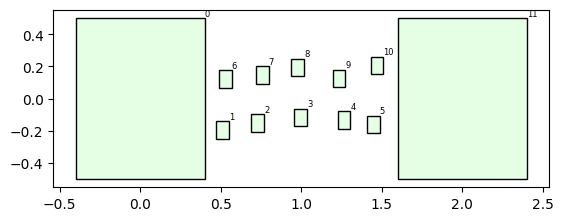

In [4]:
stone_length = .50

terrain = Terrain(
            init_center_xy=[0,0],
            target_center_xy=[2.0,0.0],
            init_wh=[0.4, 0.5],
            target_wh=[0.4, 0.5],
            num_bridges_y=2,
            num_stones_in_bridge=5,
            bridge_stone_wh=[0.04, 0.055],
            bridges_dist_y=0.33,
            bridges_centerline_y=0.0,
            rand_radius=0.3,#should be in [0,1] for no overlapped stones
            rand_seed=22,
        )
terrain.plot()

erase some bridge stones

In [5]:
# terrain.erase_bridge_stone([6,3])
# terrain.plot()

# GCS

define ideal postfoot positions for initila and target stones

In [6]:
ideal_pose = np.array([
 [ 0.37863613,  0.16325861],
 [ 0.37750298, -0.16697899],
 [-0.17336029,  0.16522129],
 [-0.17461357, -0.16670634],
 ])

# swing legs
swing_order = [0,3,1,2]

In [7]:
gcs = GCS(
            terrain=terrain,
            ideal_pose=ideal_pose,
            step_span_prunning=[1.0, 0.11, 0.5, 0.2], # [x_max, x_min, y_max, y_min] for inital pruning
            vertical_limits=[0.25, -0.3, 0.5, 0.2], # [x_max, x_min, y_max, y_min]
            horizontal_limits=[0.8, 0.2, 0.2, -0.2],
            gcs_solver=MosekSolver(),
            convex_relaxation=True,
            gcs_print_console=False, 
            max_step_len=0.4,
            swing_order=swing_order,
            bridge_stone_wh=[0.01,0.01],
            bridge_x_shift=0.04, 
            copy_vertex_count=6,
        )

# Solve
pos_fl, pos_fr, pos_rl, pos_rr, cost = gcs.GCS_footstep_planner()
step_positions_xy = np.stack([pos_fl, pos_fr, pos_rl, pos_rr], axis=1)[1:,:]

GCS: creating edge list while pruning... this may take a while if number of stones > 10
Pruning Complete: Reduced 20736 combinations to 400.
Valid foot configurations: (fl, fr, rl, rr):
[(0, 0, 0, 0), (0, 1, 0, 0), (0, 2, 0, 0), (0, 2, 0, 1), (0, 3, 0, 0), (0, 3, 0, 1), (0, 3, 0, 2), (0, 4, 0, 0), (0, 4, 0, 1), (0, 4, 0, 2), (0, 4, 0, 3), (0, 5, 0, 1), (0, 5, 0, 2), (0, 5, 0, 3), (0, 5, 0, 4), (0, 11, 0, 2), (0, 11, 0, 3), (0, 11, 0, 4), (0, 11, 0, 5), (0, 11, 0, 11), (6, 0, 0, 0), (6, 1, 0, 0), (6, 2, 0, 0), (6, 2, 0, 1), (6, 3, 0, 0), (6, 3, 0, 1), (6, 3, 0, 2), (6, 4, 0, 0), (6, 4, 0, 1), (6, 4, 0, 2), (6, 4, 0, 3), (6, 5, 0, 1), (6, 5, 0, 2), (6, 5, 0, 3), (6, 5, 0, 4), (6, 11, 0, 2), (6, 11, 0, 3), (6, 11, 0, 4), (6, 11, 0, 5), (6, 11, 0, 11), (7, 0, 0, 0), (7, 0, 6, 0), (7, 1, 0, 0), (7, 1, 6, 0), (7, 2, 0, 0), (7, 2, 0, 1), (7, 2, 6, 0), (7, 2, 6, 1), (7, 3, 0, 0), (7, 3, 0, 1), (7, 3, 0, 2), (7, 3, 6, 0), (7, 3, 6, 1), (7, 3, 6, 2), (7, 4, 0, 0), (7, 4, 0, 1), (7, 4, 0, 2), (7,

INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Found 4 unique paths, discarded 96 duplicate paths.
INFO:drake:Finished 4 rounding solutions with MOSEK.


num stones =  12 , time =  51.99071907997131
GCS successful. Extracting path...


# Configure the plant
let's summon the Spot!

In [8]:
robot_builder = RobotDiagramBuilder(time_step=1e-4)
parser = robot_builder.parser()
plant = robot_builder.plant()
ConfigureParser(parser)
parser.AddModelsFromString(load_urdf_file('models/spot.urdf'),".urdf" )
parser.AddModelsFromString(load_urdf_file('models/ground_mit.urdf'),".urdf" )
plant.set_discrete_contact_approximation(DiscreteContactApproximation.kLagged)

# add stepping stone before finalize
add_boxes_urdf_from_terrain(terrain, parser, plant, height=stone_length)

# finalize
plant.Finalize()

# model name
model = plant.GetModelInstanceByName("spot")
builder = robot_builder.builder()

# read this from urdf
p_FootFootTip=np.array([0.0, 0.0, -0.379])

## Visualization and loggers

In [9]:
# visuailize: meshcat
AddDefaultVisualization(builder, meshcat=meshcat)

# logger
state_logger = builder.AddSystem(VectorLogSink(plant.num_multibody_states()))
actuation_logger = builder.AddSystem(VectorLogSink(plant.num_actuators()))
builder.Connect(plant.get_state_output_port(), state_logger.get_input_port())
builder.Connect(plant.get_net_actuation_output_port(), actuation_logger.get_input_port())

LCM self test failed!!
Check your routing tables and firewall settings


## Custom dynamic trajectory Source
this is to be able to update during the simulation

In [10]:
# desired_q from trajopt
q_trajopt_source = builder.AddSystem(DynamicTrajectorySource(plant.num_positions()))

# desired v from trajopt
v_trajopt_source = builder.AddSystem(DynamicTrajectorySource(plant.num_velocities()))

# Contact Forces from trajopt
f_trajopt_source = builder.AddSystem(DynamicTrajectorySource(12)) 

# in_stance flag 
# (1 = Stance, 0 = Swing)
stance_source = builder.AddSystem(DynamicTrajectorySource(4)) 

## Controller

In [11]:
init_stabilization_time = 2
controller = builder.AddSystem(HybridController(
    plant, 
    Kp=np.diag([1000,1000,1000]),
    Kd=np.diag([100, 100,100]),
    Kp_stab=1000,
    Kd_stab=100,
    init_stabilization_time=init_stabilization_time,
    ))

## Diagram connections

In [12]:
# Connect Sources -> Controller
builder.Connect(q_trajopt_source.get_output_port(), controller.GetInputPort("desired_q"))
builder.Connect(v_trajopt_source.get_output_port(), controller.GetInputPort("desired_v"))
builder.Connect(f_trajopt_source.get_output_port(), controller.GetInputPort("force"))
builder.Connect(stance_source.get_output_port(), controller.GetInputPort("stance"))

# Controller -> Plant
builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

# Connect State (Plant -> Controller)
builder.Connect(plant.get_state_output_port(), controller.GetInputPort("state"))

build

In [13]:
# finalize
diagram = builder.Build()

# Simulation


In [14]:
# simulation
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
context = simulator.get_mutable_context()
plant_context = plant.GetMyContextFromRoot(context)

q0 = plant.GetPositions(plant_context)
q0[6] = stone_length + 1.0 #falling height

plant.SetPositions(plant_context, q0)


###  planner

In [15]:
step_time = 0.85
stab_time = 0.5 # stabilization time after each step
planner = OneStepPlanner(
            plant, 
            plant_context, 
            model, 
            T=step_time, # duration of one step
            N=3, # num break points in one step
            min_clearence_low=0.09,
            min_clearence_high=0.11,
            target_height=0.0+stone_length,
            gait_sequence=swing_order,
            init_stab_xyz=[0.0, 0, 0.525+stone_length],
        )

# read this from urdf of plant
planner.friction_constant = 1

##### PD params
controller.Kp=np.diag([1200,1000, 1500])
controller.Kd=np.diag([150, 150, 150])
controller.Kp_stab=1500
controller.Kd_stab=200

 Simulation

In [16]:
meshcat.StartRecording()

# initial stabilization
print('\ninital stabilization...')
q_init_traj,v_init_traj = planner.init_stabilization()
q_trajopt_source.set_trajectory(q_init_traj)
v_trajopt_source.set_trajectory(v_init_traj)
simulator.AdvanceTo(init_stabilization_time)
q_pd = plant.GetPositions(plant_context)

# plan
num_steps = len(step_positions_xy)

# pre determined step sequence
# FL, RR, FR, RF
in_stance_seq = np.tile(planner.gait_sequence, num_steps)
in_stance_seq = np.hstack([-1, in_stance_seq])


# steps
print('\ntrajectory optimizer')
for step in range(num_steps):
    # trajopt
    print(f"------------------ step {step} ------------------ ")
    planner.T = step_time
    t_sol, q_sol, v_sol, q_end, f_sol, stance_sol, f_val = planner.plan_one_step(
        step_positions_xy[step,:],
        in_stance_seq[step],
        plant_context,
    )
    

    # update trajectory source
    current_time = context.get_time()

    q_trajopt_source.set_trajectory(q_sol, t_offset=current_time)
    v_trajopt_source.set_trajectory(v_sol, t_offset=current_time)
    f_trajopt_source.set_trajectory(f_sol, t_offset=current_time)
    stance_source.set_trajectory(stance_sol, t_offset=current_time)


    simulator.AdvanceTo(current_time + t_sol[-1])
    print()

    print(f"------------------ step {step} RECOVER------------------ ")
    planner.T = stab_time
    foot_xyz = planner.get_feet_positions_from_context()
    t_rec, q_rec, v_rec, q_rec_end, f_rec, stance_rec, f_val_rec = planner.plan_one_step(
        foot_xyz[:,:2],
        -1,
        plant_context,
    )
    

    # update trajectory source
    current_time = context.get_time()

    q_trajopt_source.set_trajectory(q_rec, t_offset=current_time)
    v_trajopt_source.set_trajectory(v_rec, t_offset=current_time)
    f_trajopt_source.set_trajectory(f_rec, t_offset=current_time)
    stance_source.set_trajectory(stance_rec, t_offset=current_time)


    simulator.AdvanceTo(current_time + t_rec[-1])
    
meshcat.PublishRecording()


inital stabilization...
Init stabilizer current foot placement:
[[ 0.32285   0.165945  0.5     ]
 [ 0.32285  -0.165945  0.5     ]
 [-0.27285   0.165945  0.5     ]
 [-0.27285  -0.165945  0.5     ]]

trajectory optimizer
------------------ step 0 ------------------ 
trajopt time =  0.12082982063293457
SNOPT
True

------------------ step 0 RECOVER------------------ 
trajopt time =  0.07281303405761719
SNOPT
True
------------------ step 1 ------------------ 
trajopt time =  0.26441001892089844
SNOPT
True

------------------ step 1 RECOVER------------------ 
trajopt time =  0.06066584587097168
SNOPT
True
------------------ step 2 ------------------ 
trajopt time =  0.20679402351379395
SNOPT
True

------------------ step 2 RECOVER------------------ 
trajopt time =  0.06491684913635254
SNOPT
True
------------------ step 3 ------------------ 
trajopt time =  0.2318248748779297
SNOPT
True

------------------ step 3 RECOVER------------------ 
trajopt time =  0.05441999435424805
SNOPT
True
-----

In [17]:
# plant.SetPositions(plant_context, q0)
# diagram.ForcedPublish(context)

In [18]:
# feet_qpd = planner.get_feet_positions_from_q(q0)
# print(feet_qpd)

In [19]:
# plant.SetPositions(plant_context, q_pd)
# diagram.ForcedPublish(context)

# for step in range(num_steps):
#     # trajopt
#     t_sol, q_sol, *_ = planner.plan_one_step(
#         step_positions_xy[step,:],
#         in_stance_seq[step],
#         plant_context,
#     )
#     sample_times = np.linspace(t_sol[0], t_sol[-1], 20)
#     for t in sample_times:
#         q_t = q_sol.value(t)
#         context.SetTime(t)

#         plant.SetPositions(plant_context, q_t)
#         diagram.ForcedPublish(context)
    